<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/classification/Image_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification test 1

The purpose of this test is to:
* familiarize myself with Pytorch
* test classification performance of visible light vs visible light plus FIR

It seems as if the FIR and visible light images aren't always taken at the same time, which might be the reason why the advanced classifier performs worse.


## Load dataset

In [1]:
!wget http://adas.cvc.uab.es/webfiles/datasets/CVC-14-Visible-Fir-Day-Night/CVC-14.rar

--2019-11-12 09:59:29--  http://adas.cvc.uab.es/webfiles/datasets/CVC-14-Visible-Fir-Day-Night/CVC-14.rar
Resolving adas.cvc.uab.es (adas.cvc.uab.es)... 158.109.8.54
Connecting to adas.cvc.uab.es (adas.cvc.uab.es)|158.109.8.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3475869652 (3.2G) [application/rar]
Saving to: ‘CVC-14.rar’

CVC-14.rar           77%[==============>     ]   2.51G  3.98MB/s    in 12m 53s 

2019-11-12 10:12:22 (3.33 MB/s) - Connection closed at byte 2698851601. Retrying.

--2019-11-12 10:12:23--  (try: 2)  http://adas.cvc.uab.es/webfiles/datasets/CVC-14-Visible-Fir-Day-Night/CVC-14.rar
Connecting to adas.cvc.uab.es (adas.cvc.uab.es)|158.109.8.54|:80... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 3475869652 (3.2G), 777018051 (741M) remaining [application/rar]
Saving to: ‘CVC-14.rar’

CVC-14.rar          100%[+++++++++++++++====>]   3.24G  3.93MB/s    in 3m 29s  

2019-11-12 10:15:52 (3.55 MB/s) - ‘CVC-14.

In [2]:
!unrar x CVC-14.rar > /dev/null
!echo "finished"

finished


## Data loader

Loads visible light + FIR data.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [0]:
from os import listdir
from os import path
import cv2

class CVC14Dataset(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, train_test):
        self.root_dir = root_dir
        self.train_test = train_test
        
        self.visible_dir = path.join(root_dir, "Visible", train_test)
        self.thermal_dir = path.join(root_dir, "FIR", train_test)

        # Intersection of visible and thermal data
        intersection = list(
            set(listdir(path.join(self.visible_dir, "CropsPos"))) & \
            set(listdir(path.join(self.thermal_dir, "CropsPos"))) \
        ) 
        self.intersection = sorted(filter(lambda x: x.endswith(".tif"), intersection))


    def __len__(self):
        return len(self.intersection) * 2

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if idx >= len(self.intersection):
            def random_cutout(vis, thr):
                w = 64
                h = 128
                x = np.random.randint(0, vis.shape[0]-w)
                y = np.random.randint(0, vis.shape[1]-h)
                return vis[x:x+w, y:y+h, :], thr[x:x+w, y:y+h, :]

            fname = sorted(filter(lambda x: x.endswith(".tif"), listdir(path.join(self.visible_dir, "FramesPos"))))[idx-len(self.intersection)]
            print(idx, fname)

            fpath = path.join(self.visible_dir, "FramesPos", fname)
            vis = cv2.imread(fpath) / 128 - 1

            fpath = path.join(self.thermal_dir, "FramesPos", fname)
            thr = cv2.imread(fpath) / 128 - 1

            vis, thr = random_cutout(vis, thr)

            vis = cv2.resize(vis, (128, 128))
            vis = np.einsum("hwc->chw", vis)

            thr = cv2.resize(thr, (128, 128))
            thr = np.mean(thr, axis=2)[None, ...]

            return {
                "visible": vis,
                "thermal": thr,
                "label": 0
            }

        else:          
            fname = sorted(filter(lambda x: x.endswith(".tif"), self.intersection))[idx]
            print(idx, fname)
            # Visible
            fpath = path.join(self.visible_dir, "CropsPos", fname)
            
            vis = cv2.imread(fpath) / 128 - 1
            vis = cv2.resize(vis, (128, 128))
            vis = np.einsum("hwc->chw", vis)

            # Thermal
            fpath = path.join(self.thermal_dir, "CropsPos", fname)

            thr = cv2.imread(fpath) / 128 - 1
            thr = cv2.resize(thr, (128, 128))
            thr = np.mean(thr, axis=2)[None, ...] * -1
            # thr = thr[None, ..., 0]
            return {
                "visible": vis,
                "thermal": thr,
                "label": 1
            }
        
dataset = CVC14Dataset("Day", "Train")

In [432]:
dataset[303]["visible"].min()

303 annotations_+0.000000_2014_05_04_15_46_46_117000__0.tif


-0.734375

In [0]:
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
classes = (0, 1)

1655 2014_05_04_15_46_02_602000_.tif
888 annotations_+0.000000_2014_05_04_16_08_53_977000__2.tif
1090 annotations_+0.000000_2014_05_04_16_09_21_964000__0.tif
2154 2014_05_04_15_47_42_915000_.tif


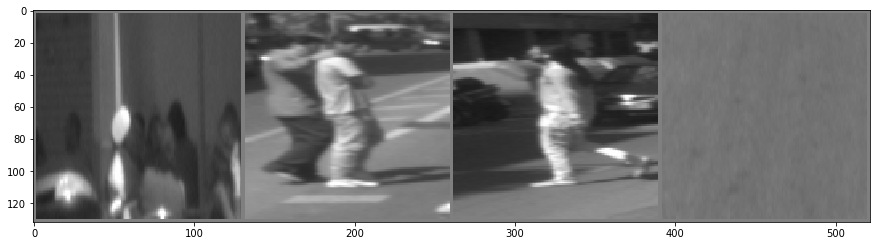

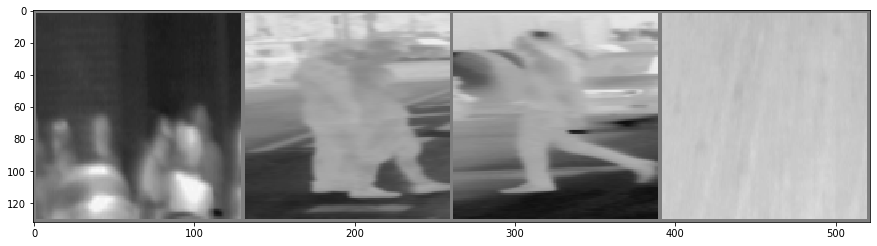

In [434]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_batch(batch):  
    visible, thermal, labels = batch["visible"], batch["thermal"], batch["label"]
    imshow(torchvision.utils.make_grid(visible))
    imshow(torchvision.utils.make_grid(thermal))

dataiter = iter(loader)
show_batch(dataiter.next())


## The model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*29*29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net = net.float()

# net(dataiter.next()["visible"].float())

In [370]:
len(loader)

547

In [371]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):
    print(f"Starting epoch {epoch}")
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["visible"].float(), data["label"]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Starting epoch 0
[1,   100] loss: 0.685
[1,   200] loss: 0.634
[1,   300] loss: 0.463
[1,   400] loss: 0.364
[1,   500] loss: 0.295
Starting epoch 1
[2,   100] loss: 0.221
[2,   200] loss: 0.201
[2,   300] loss: 0.197
[2,   400] loss: 0.153
[2,   500] loss: 0.168
Starting epoch 2
[3,   100] loss: 0.125
[3,   200] loss: 0.127
[3,   300] loss: 0.147
[3,   400] loss: 0.103
[3,   500] loss: 0.075
Starting epoch 3
[4,   100] loss: 0.167
[4,   200] loss: 0.079
[4,   300] loss: 0.104
[4,   400] loss: 0.056
[4,   500] loss: 0.089
Starting epoch 4
[5,   100] loss: 0.092
[5,   200] loss: 0.067
[5,   300] loss: 0.051
[5,   400] loss: 0.069
[5,   500] loss: 0.057
Finished Training


In [372]:
from sklearn.metrics import classification_report

test_dataset = CVC14Dataset("Night", "Train")
print(len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

all_outputs = []
all_labels = []
for i, data in enumerate(test_loader, 1000):
    inputs, labels = data["visible"].float(), data["label"]
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)
    all_outputs += predicted.tolist()
    all_labels += labels.tolist()

2698


In [373]:
print(classification_report(all_labels, all_outputs, target_names=["nothing", "human"]))

              precision    recall  f1-score   support

     nothing       0.61      0.99      0.75      1349
       human       0.99      0.35      0.52      1349

    accuracy                           0.67      2698
   macro avg       0.80      0.67      0.64      2698
weighted avg       0.80      0.67      0.64      2698



## Advanced model (including FIR)

In [0]:
class CombinedNet(nn.Module):
    def __init__(self):
        super(CombinedNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

comb_net = CombinedNet()
comb_net = comb_net.float()


In [375]:
dataiter = iter(loader)
data = dataiter.next()

visible, thermal, labels = data["visible"].float(), data["thermal"].float(), data["label"]
inputs = torch.cat([visible, thermal], 1)

print(inputs.shape)
comb_net(inputs)

torch.Size([4, 4, 128, 128])


tensor([[-0.0129, -0.0502],
        [-0.0044, -0.0606],
        [-0.0103, -0.0533],
        [-0.0125, -0.0506]], grad_fn=<AddmmBackward>)

In [376]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(comb_net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):
    print(f"Starting epoch {epoch}")
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        visible, thermal, labels = data["visible"].float(), data["thermal"].float(), data["label"]
        inputs = torch.cat([visible, thermal], 1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = comb_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Starting epoch 0
[1,   100] loss: 0.667
[1,   200] loss: 0.487
[1,   300] loss: 0.331
[1,   400] loss: 0.285
[1,   500] loss: 0.183
Starting epoch 1
[2,   100] loss: 0.253
[2,   200] loss: 0.185
[2,   300] loss: 0.184
[2,   400] loss: 0.196
[2,   500] loss: 0.124
Starting epoch 2
[3,   100] loss: 0.144
[3,   200] loss: 0.181
[3,   300] loss: 0.126
[3,   400] loss: 0.117
[3,   500] loss: 0.106
Starting epoch 3
[4,   100] loss: 0.092
[4,   200] loss: 0.118
[4,   300] loss: 0.080
[4,   400] loss: 0.085
[4,   500] loss: 0.085
Starting epoch 4
[5,   100] loss: 0.063
[5,   200] loss: 0.081
[5,   300] loss: 0.065
[5,   400] loss: 0.064
[5,   500] loss: 0.077
Finished Training


In [377]:
test_dataset = CVC14Dataset("Night", "Train")
print(len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

all_outputs = []
all_labels = []
for i, data in enumerate(test_loader, 1000):
    visible, thermal, labels = data["visible"].float(), data["thermal"].float(), data["label"]
    inputs = torch.cat([visible, thermal], 1)
    outputs = comb_net(inputs)
    _, predicted = torch.max(outputs, 1)
    all_outputs += predicted.tolist()
    all_labels += labels.tolist()

2698


In [378]:
print(classification_report(all_labels, all_outputs, target_names=["ham", "human"]))

              precision    recall  f1-score   support

         ham       0.50      1.00      0.67      1349
       human       0.77      0.01      0.02      1349

    accuracy                           0.50      2698
   macro avg       0.64      0.50      0.35      2698
weighted avg       0.64      0.50      0.35      2698

